In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from models import *
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [4]:
def get_dataloaders(batch_size=128, num_workers=4):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=num_workers)

    return trainloader, testloader

In [5]:
# Constants
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainloader, testloader = get_dataloaders()
num_epochs = 25
model_name = 'ResNet18'

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=25, scheduler=None):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    pbar_epochs = tqdm(total=num_epochs, desc='Overall Progress', position=0)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        pbar_batches = tqdm(total=len(trainloader), desc=f'Epoch {epoch+1}/{num_epochs}', position=1, leave=False)
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(criterion, nn.CrossEntropyLoss):
                loss = criterion(outputs, labels)
            else:
                labels_onehot = F.one_hot(labels, num_classes=10).to(torch.float)
                loss = criterion(outputs, labels_onehot)
            
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            pbar_batches.set_postfix(loss=loss.item())
            pbar_batches.update()

        pbar_batches.close()
        epoch_train_loss = running_loss / len(trainloader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Print training statistics
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}')
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(criterion, nn.CrossEntropyLoss):
                    loss = criterion(outputs, labels)
                else:
                    labels_onehot = F.one_hot(labels, num_classes=10).to(torch.float)
                    loss = criterion(outputs, labels_onehot)

                running_test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        epoch_test_loss = running_test_loss / len(testloader.dataset)
        epoch_test_acc = correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        # print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}')
        pbar_epochs.set_postfix(train_loss=epoch_train_loss, train_acc=epoch_train_acc, test_loss=epoch_test_loss, test_acc=epoch_test_acc)
        pbar_epochs.update()
    pbar_epochs.close()
    print('Training complete!')
    print(f'Training Accuracy: {train_accuracies[-1]}, Best Test Accuracy: {max(test_accuracies)}')
    return train_losses, train_accuracies, test_losses, test_accuracies

In [8]:
def plot_curves(train_losses, train_accuracies, test_losses, test_accuracies, item_names):

    num_functions = len(item_names)
    
    # Plotting results
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    for i in range(num_functions):
        plt.plot(train_losses[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 2)
    for i in range(num_functions):
        plt.plot(train_accuracies[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Plot test loss
    plt.subplot(2, 2, 3)
    for i in range(num_functions):
        plt.plot(test_losses[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for i in range(num_functions):
        plt.plot(test_accuracies[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Try different loss functions

In [9]:
loss_functions = {
    'CrossEntropy': nn.CrossEntropyLoss(),
    'BCEWithLogits': nn.BCEWithLogitsLoss(),
    'MSE': nn.MSELoss(),
    # Huber loss is equivalent to SmoothL1Loss in PyTorch
    'Huber': nn.SmoothL1Loss(),
    'SoftMargin': nn.MultiLabelSoftMarginLoss()
}

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'==> Training {model_name} on CIFAR-10')
for loss_name, criterion in loss_functions.items():
    print(f'==> Training with {loss_name}...')
    model = ResNet18()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

loss_function_names = list(loss_functions.keys())
plot_curves(all_train_losses, all_train_accuracies,
                   all_test_losses, all_test_accuracies, loss_function_names)

==> Training ResNet18 on CIFAR-10
==> Training with CrossEntropy...


Overall Progress:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Try different weight decay

==> Training ResNet18 on CIFAR-10
==> Training with Weight Decay 0.01...


Overall Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Overall Progress: 100%|██████████| 25/25 [08:46<00:00, 21.05s/it, test_acc=0.7, test_loss=0.967, train_acc=0.838, train_loss=0.497]  


Training complete!
Training Accuracy: 0.83788, Best Test Accuracy: 0.7999
==> Training with Weight Decay 0.001...


Overall Progress: 100%|██████████| 25/25 [08:46<00:00, 21.05s/it, test_acc=0.878, test_loss=0.379, train_acc=0.94, train_loss=0.173] 


Training complete!
Training Accuracy: 0.93998, Best Test Accuracy: 0.8958
==> Training with Weight Decay 0.005...


Overall Progress: 100%|██████████| 25/25 [08:45<00:00, 21.04s/it, test_acc=0.854, test_loss=0.446, train_acc=0.884, train_loss=0.351]


Training complete!
Training Accuracy: 0.88388, Best Test Accuracy: 0.8535
==> Training with Weight Decay 0.0001...


Overall Progress: 100%|██████████| 25/25 [08:47<00:00, 21.09s/it, test_acc=0.892, test_loss=0.39, train_acc=0.954, train_loss=0.131] 


Training complete!
Training Accuracy: 0.95362, Best Test Accuracy: 0.8985
==> Training with Weight Decay 0.0005...


Overall Progress: 100%|██████████| 25/25 [08:53<00:00, 21.35s/it, test_acc=0.887, test_loss=0.384, train_acc=0.951, train_loss=0.143]


Training complete!
Training Accuracy: 0.95052, Best Test Accuracy: 0.8984


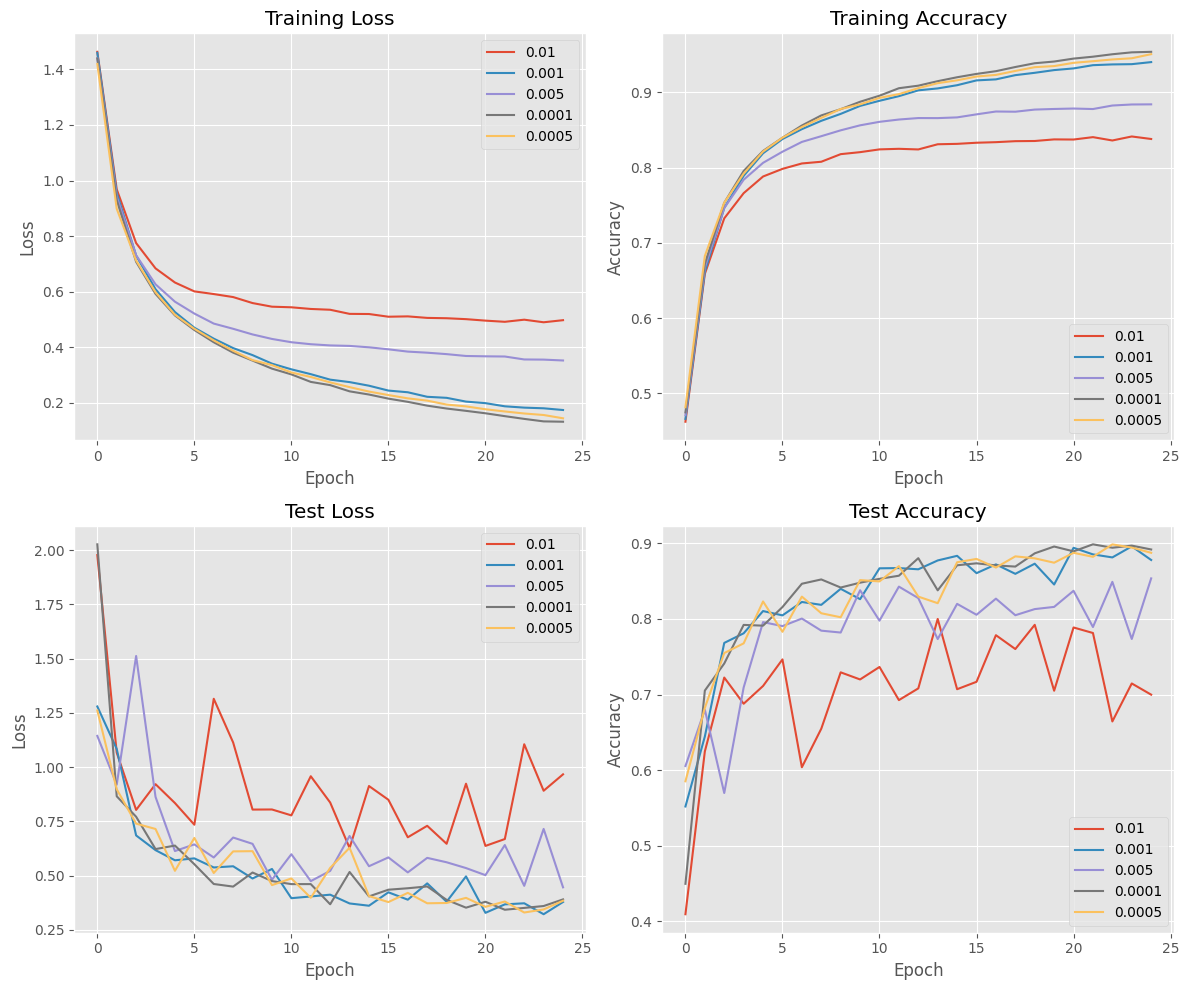

In [8]:
l2_coeffs = [0.01, 0.001, 0.005, 1e-4, 5e-4]

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'==> Training {model_name} on CIFAR-10')
for l2_coeff in l2_coeffs:
    print(f'==> Training with Weight Decay {l2_coeff}...')
    model = ResNet18()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_coeff)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

plot_curves(all_train_losses, all_train_accuracies,
                   all_test_losses, all_test_accuracies, l2_coeffs)

## Try different activations

==> Training ResNet18 on CIFAR-10
==> Training with ReLU...


Overall Progress: 100%|██████████| 25/25 [08:47<00:00, 21.09s/it, test_acc=0.894, test_loss=0.352, train_acc=0.947, train_loss=0.152]


Training complete!
Training Accuracy: 0.94686, Best Test Accuracy: 0.8945
==> Training with Leaky ReLU...


Overall Progress: 100%|██████████| 25/25 [08:45<00:00, 21.02s/it, test_acc=0.887, test_loss=0.391, train_acc=0.948, train_loss=0.149]


Training complete!
Training Accuracy: 0.94818, Best Test Accuracy: 0.8932
==> Training with ELU...


Overall Progress: 100%|██████████| 25/25 [08:45<00:00, 21.02s/it, test_acc=0.87, test_loss=0.4, train_acc=0.892, train_loss=0.31]    


Training complete!
Training Accuracy: 0.8925, Best Test Accuracy: 0.875
==> Training with GELU...


Overall Progress: 100%|██████████| 25/25 [08:45<00:00, 21.01s/it, test_acc=0.893, test_loss=0.353, train_acc=0.954, train_loss=0.132]


Training complete!
Training Accuracy: 0.95364, Best Test Accuracy: 0.9019


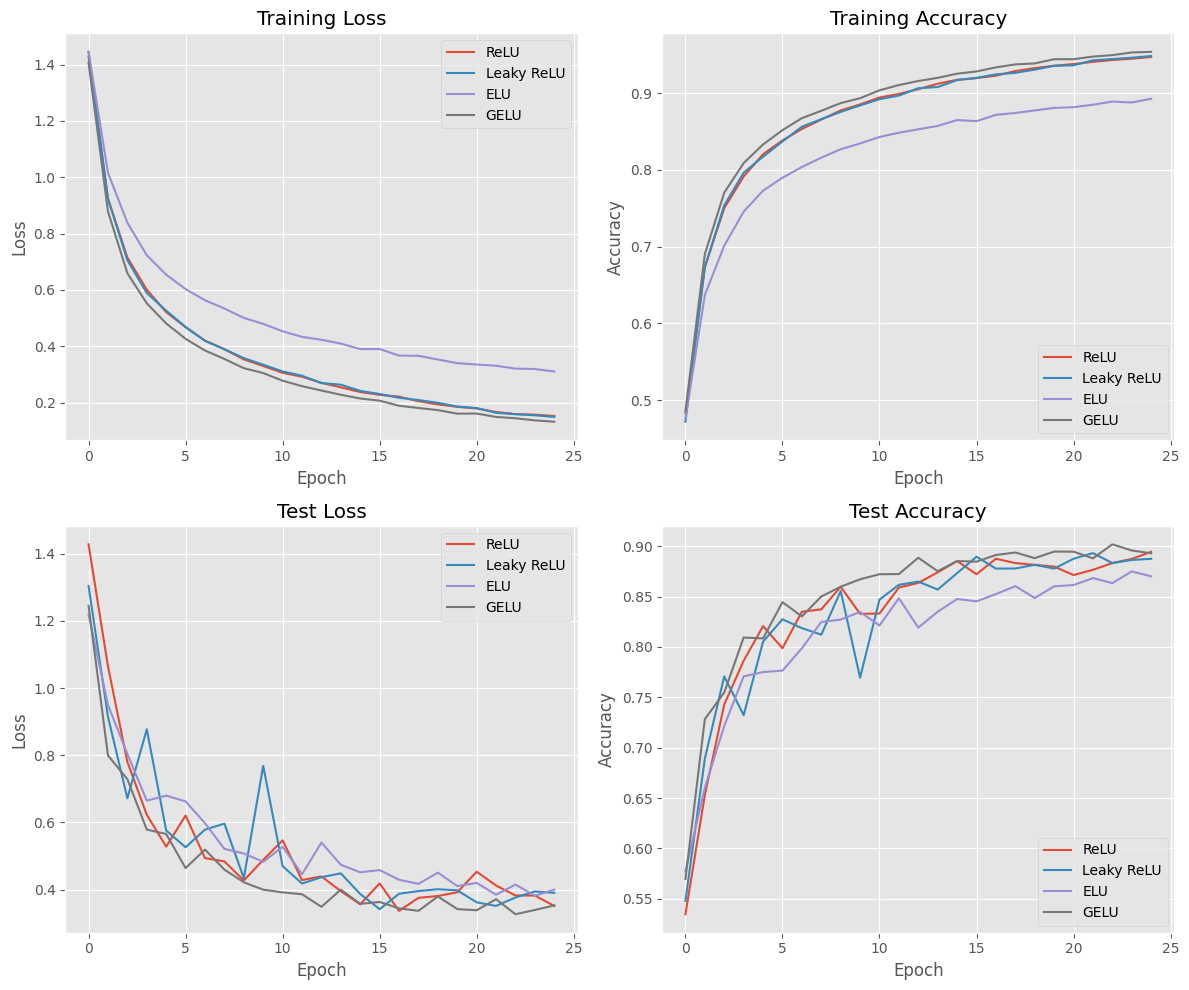

In [9]:
activations = {
    'ReLU': ResNet18(),
    'Leaky ReLU': ResNet18_LeakyReLU(),
    'ELU': ResNet18_ELU(),
    'GELU': ResNet18_GELU()
}

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'==> Training {model_name} on CIFAR-10')
for act_name, model in activations.items():
    print(f'==> Training with {act_name}...')
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

activation_names = list(activations.keys())
plot_curves(all_train_losses, all_train_accuracies,
                   all_test_losses, all_test_accuracies, activation_names)

## Try different optimizers

==> Training ResNet18 on CIFAR-10
==> Training with SGD...


Overall Progress: 100%|██████████| 25/25 [08:45<00:00, 21.04s/it, test_acc=0.885, test_loss=0.392, train_acc=0.949, train_loss=0.142]


Training complete!
Training Accuracy: 0.94912, Best Test Accuracy: 0.892
==> Training with Adagrad...


Overall Progress: 100%|██████████| 25/25 [08:52<00:00, 21.31s/it, test_acc=0.894, test_loss=0.337, train_acc=0.946, train_loss=0.155]


Training complete!
Training Accuracy: 0.94572, Best Test Accuracy: 0.8944
==> Training with Adadelta...


Overall Progress: 100%|██████████| 25/25 [08:57<00:00, 21.48s/it, test_acc=0.82, test_loss=0.546, train_acc=0.872, train_loss=0.368] 


Training complete!
Training Accuracy: 0.87234, Best Test Accuracy: 0.8201
==> Training with Adam...


Overall Progress: 100%|██████████| 25/25 [08:52<00:00, 21.31s/it, test_acc=0.689, test_loss=0.947, train_acc=0.722, train_loss=0.798]


Training complete!
Training Accuracy: 0.72236, Best Test Accuracy: 0.6963
==> Training with Adamax...


Overall Progress: 100%|██████████| 25/25 [09:06<00:00, 21.87s/it, test_acc=0.808, test_loss=0.584, train_acc=0.832, train_loss=0.486]


Training complete!
Training Accuracy: 0.83214, Best Test Accuracy: 0.8085


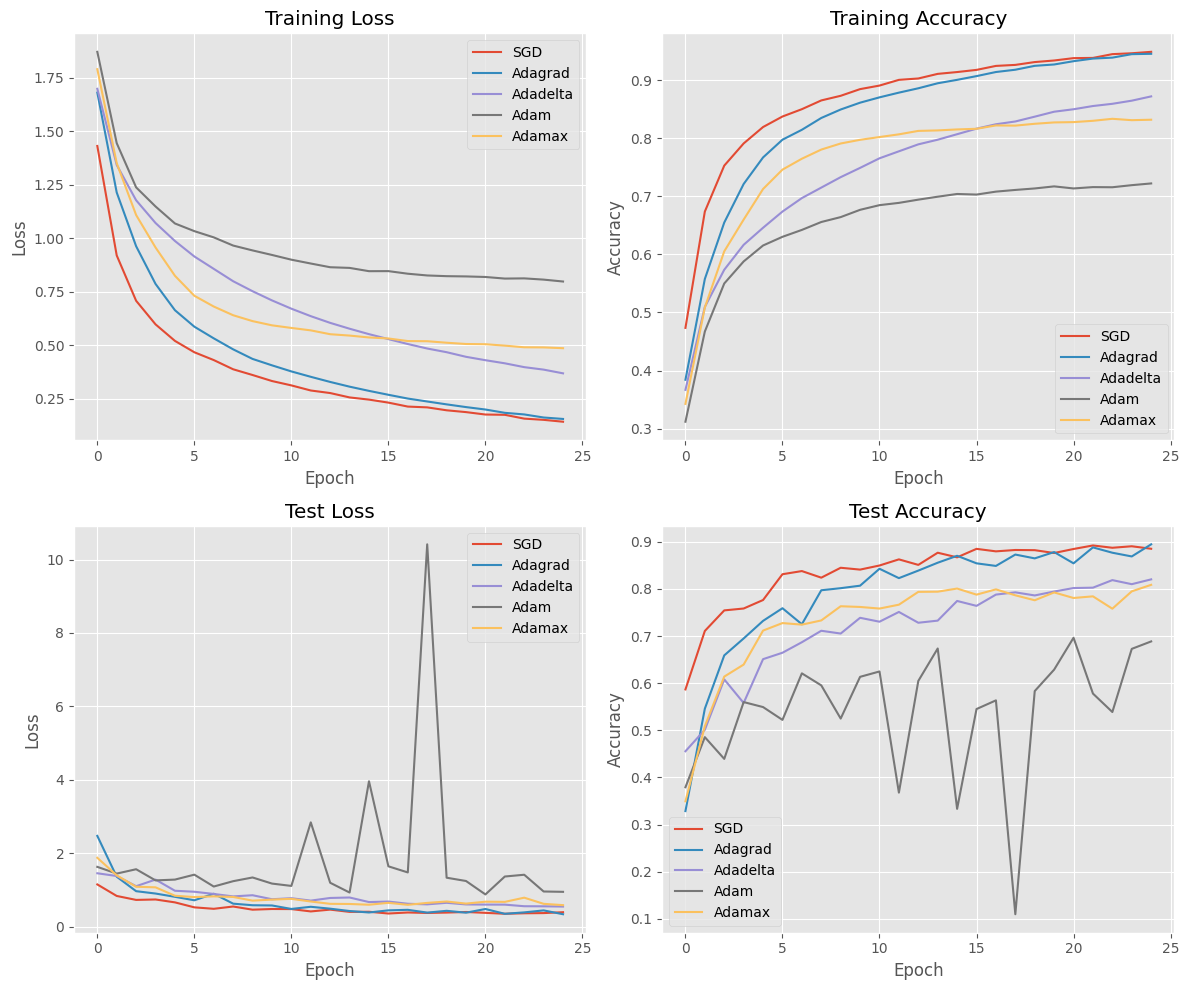

In [18]:
optimizers = [
    'SGD',
    'Adagrad',
    'Adadelta',
    'Adam',
    'Adamax'
]

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []


print(f'==> Training {model_name} on CIFAR-10')
for opt in optimizers:
    print(f'==> Training with {opt}...')
    model = ResNet18()
    model = model.to(device)
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01,
        momentum=0.9, weight_decay=5e-4)
    elif opt == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    elif opt == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=0.01,
        weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, cooldown=5, min_lr=1e-6)
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, trainloader, testloader, criterion, optimizer, num_epochs, scheduler)

    # Append results to lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)

plot_curves(all_train_losses, all_train_accuracies,
                   all_test_losses, all_test_accuracies, optimizers)